In [1]:
from transformers import AutoTokenizer,LlamaConfig,GenerationConfig
import torch
import os
import pandas as pd
import numpy as np
import pickle
import glob
import re
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances
import string
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statannotations.Annotator import Annotator
from statsmodels.stats import multitest
from statsmodels.stats.anova import AnovaRM 
import itertools
import sys
sys.path.append('/home/jianing/generation/Memory_generation')
from utils import get_segmentation_indices,segmentation_to_word_list
from utils import calculate_cross_entropy,normalize_entropy,model_to_path_dict

In [2]:
def get_significance(p_val):
    if p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    else:
        return "ns"
    
def add_brackets(ax, pair, significance, bars, offset):
    # Get the index of the bars from the pair
    bar1_index = list(means.index).index(pair[0])
    bar2_index = list(means.index).index(pair[1])
    
    # Get the y-values of the bars for each pair
    y1 = bars[bar1_index].get_height() + bars[bar1_index].get_y()
    y2 = bars[bar2_index].get_height() + bars[bar2_index].get_y()

    # Determine the max y for placing the bracket and label
    y_max = max(y1, y2) + offset  # Add space between brackets
    
    # Add the line (bracket) between the two bars
    ax.plot([bar1_index, bar2_index], [y_max, y_max], color='black', lw=2)
    
    # Add significance stars or "ns" above the bracket
    ax.text((bar1_index + bar2_index) / 2, y_max, significance, ha='center', va='bottom', fontsize=7)


In [3]:
uniform_preds = ['weighted_event_info_by_duration','weighted_event_info','weighted_event_info_conditioned']
controls = ['H(event|prev events)','H(event)','event_len','event_duration']

In [ ]:
plotting_label_dict = {
    "weighted_event_info": "CRUISE (Number of tokens)",
    "weighted_event_info_by_duration": "CRUISE (Duration)", 
    "weighted_event_info_conditioned": "Surprise-weighted sampling",
    'H(event|prev events)': "Surprisal",
    'H(event)': "Total information",
    'event_duration': "Duration",
    "event_len": "Number of tokens",
}
plotting_label_dict_sm = {
    "weighted_event_info_by_duration": "CRUISE", 
    "weighted_event_info_conditioned": "Surprisal-weighted sampling",
    'H(event|prev events)': "Surprisal",
    'H(event)': "Total information",
    'event_duration': "Duration",
    "event_len": "Number of tokens",
}
plot_fontsize = 8

In [ ]:
adjusted = True
save_dir = '/home/jianing/generation/generated'
model_name = 'Llama3-8b-instruct' #'Llama3-8b'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
figure_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding','figures_even_split','adjusted')

if adjusted:
    uniform_encoding_df_name = 'uniform_encoding_df_even_split_adjusted.csv'
    mutual_info_save_dir_name = 'story_split_timing_adjusted'
    figure_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding','figures_even_split','adjusted')
else:
    uniform_encoding_df_name = 'uniform_encoding_df_even_split.csv'
    mutual_info_save_dir_name = 'story_split_timing'
    figure_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding','figures_even_split')
if not os.path.exists(figure_save_dir):
    os.makedirs(figure_save_dir)

exclusion_dir = os.path.join('/home/jianing/generation/behavior_data/','exclusion')
stories = ['pieman','alternateithicatom','odetostepfather','souls','legacy','wheretheressmoke','adventuresinsayingyes','inamoment']
story_to_idx_mapping = {s:stories.index(s)+1 for s in stories}

uniform_preds_colors = {p:sns.color_palette("light:#005F5F_r", len(uniform_preds)+1)[i] for i,p in enumerate(uniform_preds)}
controls_colors= {p:sns.color_palette("light:#FFBF00", len(controls)+1)[i+1] for i,p in enumerate(controls)}
all_colors = {**uniform_preds_colors, **controls_colors}

instruct = False
recall_first = True

all_stories_corr_df = []
for story in stories:
    exclusion_df = pd.read_csv(os.path.join(exclusion_dir,'%s_exclusion.csv'%story))
    excluded_subjects = exclusion_df['excluded'].loc[exclusion_df['recall']==1].values 

    pairwise_event_save_dir = os.path.join(save_dir,model_save_dir_name,'pairwise_event',story,mutual_info_save_dir_name)
    recall_explained_event_info_df_raw = pd.read_csv(os.path.join(pairwise_event_save_dir,'recall_explained_event_ce_df.csv'))
    recall_explained_event_info_df_raw = recall_explained_event_info_df_raw[~recall_explained_event_info_df_raw['subject'].isin(excluded_subjects)]

    event_explained_recall_info_df_raw = pd.read_csv(os.path.join(pairwise_event_save_dir,'event_explained_recall_ce_df.csv'))
    event_explained_recall_info_df_raw = event_explained_recall_info_df_raw[~event_explained_recall_info_df_raw['subject'].isin(excluded_subjects)]

    recall_explained_event_info_df_instruct = pd.read_csv(os.path.join(pairwise_event_save_dir,'instruct','recall_explained_event_ce_df.csv'))
    recall_explained_event_info_df_instruct = recall_explained_event_info_df_instruct[~recall_explained_event_info_df_instruct['subject'].isin(excluded_subjects)]

    event_explained_recall_info_df_instruct = pd.read_csv(os.path.join(pairwise_event_save_dir,'instruct','event_explained_recall_ce_df.csv'))
    event_explained_recall_info_df_instruct = event_explained_recall_info_df_instruct[~event_explained_recall_info_df_instruct['subject'].isin(excluded_subjects)]

    uniform_encoding_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding',story)
    story_uniform_encoding_df = pd.read_csv(os.path.join(uniform_encoding_save_dir,uniform_encoding_df_name))
    
    subjects = []
    uniform_token_corr = []
    uniform_duration_corr = []
    uniform_conditioned_corr = []
    H_event_conditioned_corr = []
    H_event_corr = []
    duration_corr = []
    num_tokens_corr = []
    if instruct:
        if recall_first:
            target_df = recall_explained_event_info_df_instruct
        else:
            target_df = event_explained_recall_info_df_instruct
    else:
        if recall_first:
            target_df = recall_explained_event_info_df_raw
        else:
            target_df = event_explained_recall_info_df_raw
    
    for subject,subject_df in target_df.groupby('subject'):
        ER_intersect = subject_df['ER_intersect'].values
        uniform_token_corr.append(np.corrcoef(ER_intersect,story_uniform_encoding_df['weighted_event_info'])[0,1])
        uniform_duration_corr.append(np.corrcoef(ER_intersect,story_uniform_encoding_df['weighted_event_info_by_duration'])[0,1])
        uniform_conditioned_corr.append(np.corrcoef(ER_intersect,story_uniform_encoding_df['weighted_event_info_conditioned'])[0,1])
        H_event_conditioned_corr.append(np.corrcoef(ER_intersect,story_uniform_encoding_df['H(event|prev events)'])[0,1])
        H_event_corr.append(np.corrcoef(ER_intersect,story_uniform_encoding_df['H(event)'])[0,1])
        duration_corr.append(np.corrcoef(ER_intersect,story_uniform_encoding_df['event_duration'])[0,1])
        num_tokens_corr.append(np.corrcoef(ER_intersect,story_uniform_encoding_df['event_len'])[0,1])
        subjects.append(subject)
    recall_first_corr_df = pd.DataFrame({'subject':subjects,
                                         'weighted_event_info_by_duration':uniform_duration_corr,
                                        'weighted_event_info':uniform_token_corr,                       
                                        'weighted_event_info_conditioned':uniform_conditioned_corr,
                                        'H(event|prev events)':H_event_conditioned_corr,
                                        'H(event)':H_event_corr,
                                        'event_len':num_tokens_corr,
                                        'event_duration':duration_corr,
                                        'story':story})
    
    all_stories_corr_df.append(recall_first_corr_df)
all_stories_corr_df = pd.concat(all_stories_corr_df, ignore_index =True)

In [143]:
if recall_first and not instruct:
    plot_target = 'mean_ER_intersect'
    recall_str = 'recall first'
    inst_str = 'direct concatenation'
elif recall_first and instruct:
    plot_target = 'mean_ER_intersect_instruct'
    recall_str = 'recall first'
    inst_str = 'instruction prompted'
elif not recall_first and not instruct:
    plot_target = 'mean_ER_intersect_recall_last'
    recall_str = 'recall last'
    inst_str = 'direct concatenation'
elif not recall_first and instruct:
    plot_target = 'mean_ER_intersect_instruct_recall_last'
    recall_str = 'recall last'
    inst_str = 'instruction prompted'

## test within story separately 

In [78]:
all_story_p = {}
all_story_prop ={}
all_story_corrected_p = {}
for story in stories:
    this_story_df = all_stories_corr_df.loc[all_stories_corr_df['story']==story]
    this_story_p_matrix = pd.DataFrame(np.nan, index=uniform_preds, columns=controls+['weighted_event_info_conditioned'])
    this_story_prop_matrix = pd.DataFrame(np.nan, index=uniform_preds, columns=controls+['weighted_event_info_conditioned'])
    n = len(this_story_df)
    for pred in uniform_preds:
        for control_pred in controls+['weighted_event_info_conditioned']:
            if pred==control_pred:
                continue
            successes = np.sum(this_story_df[pred]>this_story_df[control_pred])
            p = stats.binomtest(successes, n=n, p=0.5, alternative='greater')
            this_story_p_matrix.loc[pred,control_pred] = p.pvalue
            this_story_prop_matrix.loc[pred,control_pred] =p.statistic
    this_story_pvals_flat = this_story_p_matrix.values.flatten()[:-1] # last one is np.nan cuz no comparison to itself
    _, this_story_pvals_corrected, _, _ = multitest.multipletests(this_story_pvals_flat, method='fdr_bh')
    this_story_pvals_corrected = np.append(this_story_pvals_corrected,np.nan)
    this_story_corrected_p_matrix = pd.DataFrame(
        this_story_pvals_corrected.reshape(this_story_p_matrix.shape),
        index=this_story_p_matrix.index,
        columns=this_story_p_matrix.columns
    )

    all_story_p[story] = this_story_p_matrix
    all_story_prop[story] = this_story_prop_matrix
    all_story_corrected_p[story] = this_story_corrected_p_matrix

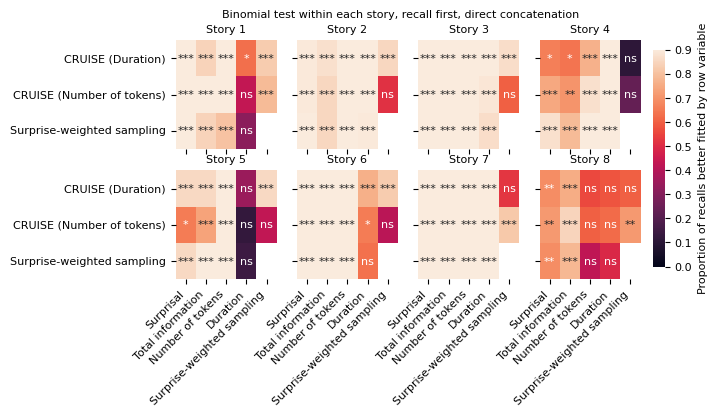

In [164]:
# uncorrected first level matrix (we feed this into second level )
fig, axs = plt.subplots(2, 4, figsize = (6,3.1),sharey=True,sharex = True)  # Adjust the number of subplots as needed
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position for the shared color bar
axs = axs.flatten()  # Flatten the 2D array of axes

for i,(ax,story) in enumerate(zip(axs,all_story_p.keys())):
    this_story_prop_matrix = all_story_prop[story]
    corrected_p_values=all_story_p[story]
    significance_matrix = corrected_p_values.applymap(lambda p: get_significance(p) if not pd.isna(p) else "")
    

    sns.heatmap(this_story_prop_matrix, annot=significance_matrix, 
                annot_kws ={'fontsize':plot_fontsize},
                fmt="", 
                cbar=i == 0,  # Add color bar only to the first heatmap
                cbar_ax=None if i > 0 else cbar_ax,  # Share color bar
                ax=ax,
                vmin = 0, vmax = 0.9,
               xticklabels = [plotting_label_dict[s] for s in this_story_prop_matrix.columns],
               yticklabels = [plotting_label_dict[s] for s in this_story_prop_matrix.index],)
    ax.set_title('Story '+str(story_to_idx_mapping[story]),fontsize = plot_fontsize)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right',fontsize = plot_fontsize)
    if i%4==0:
        ax.set_yticklabels(ax.get_yticklabels(), fontsize = plot_fontsize)
cbar_ax.tick_params(axis='both', labelsize=plot_fontsize)
cbar_ax.set_ylabel('Proportion of recalls better fitted by row variable', fontsize=plot_fontsize)
fig.suptitle("Binomial test within each story, %s, %s"%(recall_str,inst_str),fontsize = plot_fontsize)
fig.savefig(os.path.join(figure_save_dir,'first_level_matrix_%s_%s.svg'%(recall_str,inst_str)),transparent = True)

In [165]:
figure_save_dir

'/home/jianing/generation/generated/llama3-8b-instruct/uniform_encoding/figures_even_split/adjusted'

### second level binomial test 

In [98]:
num_significant_stories = pd.DataFrame(0, index=uniform_preds, columns=controls+['weighted_event_info_conditioned'])
for pred in uniform_preds:
    for control_pred in controls+['weighted_event_info_conditioned']:
        if pred==control_pred:
            num_significant_stories.loc[pred,control_pred]=np.nan
        for story in stories:
            pval = all_story_p[story].loc[pred,control_pred]
            if pval<0.05:
                num_significant_stories.loc[pred,control_pred]+=1
                

In [101]:
second_lvl_p = pd.DataFrame(np.nan, index=uniform_preds, columns=controls+['weighted_event_info_conditioned'])

for pred in uniform_preds:
    for control_pred in controls+['weighted_event_info_conditioned']:
        if pred==control_pred:
            continue
        num_sig = num_significant_stories.loc[pred,control_pred]
        p = stats.binomtest(int(num_sig),n=len(stories),p=0.05,alternative ='greater')
        second_lvl_p.loc[pred,control_pred] = p.pvalue

In [182]:
stats.binomtest(3,n=len(stories),p=0.05,alternative ='greater')

BinomTestResult(k=3, n=8, alternative='greater', statistic=0.375, pvalue=0.0057882179296875)

In [172]:
num_significant_stories[num_significant_stories.index!='weighted_event_info']

,H(event|prev events),H(event),event_len,event_duration,weighted_event_info_conditioned
weighted_event_info_by_duration,8,8,7,6,5.0
weighted_event_info_conditioned,8,8,7,4,NaN


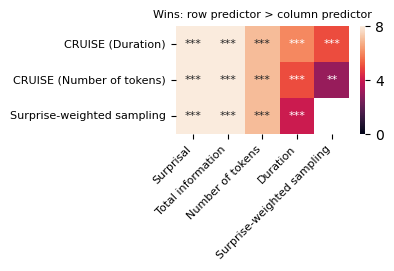

In [178]:
significance_matrix = second_lvl_p.applymap(lambda p: get_significance(p) if not pd.isna(p) else "")
fig,ax = plt.subplots(figsize = (2.8,1.4))

sns.heatmap(num_significant_stories, annot=significance_matrix, 
            annot_kws ={'fontsize':plot_fontsize},
            fmt="", 
            vmin = 0, vmax = 8,
            ax=ax,
           xticklabels = [plotting_label_dict[s] for s in num_significant_stories.columns],
           yticklabels = [plotting_label_dict[s] for s in num_significant_stories.index],
           cbar_kws={'ticks':[0,4,8]})

ax.set_yticklabels(ax.get_yticklabels(), ha='right',fontsize = plot_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right',fontsize = plot_fontsize)
ax.set_title('Wins: row predictor > column predictor',fontsize = plot_fontsize)
fig.savefig(os.path.join(figure_save_dir,'second_level_matrix_full_%s_%s.svg'%(recall_str,inst_str)),transparent = True)

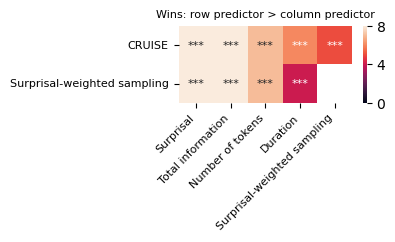

In [176]:
significance_matrix = second_lvl_p.applymap(lambda p: get_significance(p) if not pd.isna(p) else "")
fig,ax = plt.subplots(figsize = (2.8,1))

num_significant_stories_sm = num_significant_stories[num_significant_stories.index!='weighted_event_info']
significance_matrix_sm = significance_matrix[significance_matrix.index!='weighted_event_info']
sns.heatmap(num_significant_stories_sm, annot=significance_matrix_sm, 
            annot_kws ={'fontsize':plot_fontsize},
            fmt="", 
            vmin = 0, vmax = 8,
            ax=ax,
           xticklabels = [plotting_label_dict_sm[s] for s in num_significant_stories_sm.columns],
           yticklabels = [plotting_label_dict_sm[s] for s in num_significant_stories_sm.index],
           cbar_kws={'ticks':[0,4,8]})

ax.set_yticklabels(ax.get_yticklabels(), ha='right',fontsize = plot_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right',fontsize = plot_fontsize)
ax.set_title('Wins: row predictor > column predictor',fontsize = plot_fontsize)
fig.savefig(os.path.join(figure_save_dir,'second_level_matrix_%s_%s.svg'%(recall_str,inst_str)),transparent = True)